# Comparing DCT Types

The different versions of DCT really come from [different periodic extensions](https://en.wikipedia.org/wiki/Discrete_cosine_transform#Informal_overview). From [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf) we know it's convenient to use the DCT-I, but it's worth asking which variant is actually the "best" in some kind of measurable error sense.

In [1]:
import numpy as np
from scipy.fft import dct
from matplotlib import pyplot

## A Scheme

Let's:
1. take a function, and sample it at `N + 1` points to create a vector,
2. DCT that vector using various definitions, then
3. inverse DCT using the appropriate inverses with `N + 1` cosine modes so we can
4. see how close we get.

We'll need to work with an *even* function, but we create this by picking any function to the right side of zero and reflecting it back across the axis. So let's work with the one-sided domain, $[0, \pi]$. We choose $\pi$ as the endpoint and make it inclusive, because $\cos(\pi) =-1$ is inclusive in the Chebyshev domain, $[-1, 1]$, and because the DCT has a domain half the length of the DFT, which is $2\pi$. See the [figures here](https://en.wikipedia.org/wiki/Discrete_cosine_transform#Informal_overview).

In [2]:
def make_domain(N):
    th = np.linspace(0, np.pi, 100) # dense samples of a domain
    th_n = np.linspace(0, np.pi, N + 1) # a subsampling of the domain
    return th, th_n

Now let's do the scheme.

In [3]:
def compare_dct(f, N):
    """plot reconstructions of a function based on N+1 DCT modes, and compare them to that function
    :param f: function to try to reconstruct
    :param N: f is sampled at N+1 points, making the last index N. Note this is different from the N used by
                https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html
    """
    th, th_n = make_domain(N)
    pyplot.figure(figsize=(12,5))
    
    y = f(th)
    pyplot.plot(th, y, 'k', label=r'$f(\theta)$') # where the real function lives
    
    y_n = f(th_n)
    pyplot.plot(th_n, y_n, 'k+', label='samples') # where the real function samples live

    Y_1 = dct(y_n, 1)
    # reconstruct according to the DCT-I formula, which is its own inverse
    y_th_1 = Y_1[0] + Y_1[N]*(-1)**N
    for k in range(1, N):
    	y_th_1 += 2*Y_1[k]*np.cos(th*k) # continuous th takes the place of th_n = pi*n/N
    y_th_1 /= (2*N)
    pyplot.plot(th, y_th_1, 'b', label='DCT-I interpolation') # plot the full interpolation lives

    Y_2 = dct(y_n, 2)
    # reconstruct according to the DCT-III formula, which is the inverse of DCT-II
    y_th_23 = Y_2[0]
    for k in range(1, N+1):
    	y_th_23 += 2*Y_2[k]*np.cos((k/(N+1))*(N*th + np.pi/2))
    y_th_23 /= (2*N)
    pyplot.plot(th, y_th_23, 'r', label='DCT-II,III interpolation')

    Y_4 = dct(y_n, 4)
    # reconstruct according to the DCT-IV formula, which is its own inverse
    y_th_4 = 0
    for k in range(0, N+1):
    	y_th_4 += 2*Y_4[k] * np.cos((2*th * N + np.pi)*(2*k + 1)/(4*N + 4))
    y_th_4 /= (2*N)
    pyplot.plot(th, y_th_4, 'g--', label='DCT-IV interpolation')

    print("I error", np.sum((y - y_th_1)**2)/len(th)) # use the samples to produce errors
    print("II,III error", np.sum((y - y_th_23)**2)/len(th))
    print("IV error", np.sum((y - y_th_4)**2)/len(th))

    pyplot.legend()
    pyplot.show()

## Comparison

I error 6.385727448827904
II,III error 0.6542674375327767
IV error 3.8043792356038426


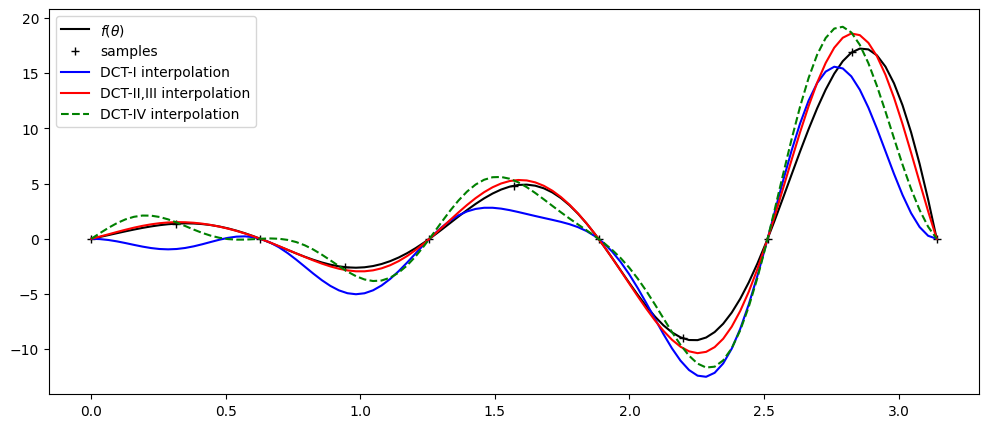

In [4]:
compare_dct(lambda th: np.exp(th) * np.sin(5*th), 10)

So the DCT-I actually does the *worst* to reconstruct the function with very few modes, and the DCT-II,III pair does best, which may explain why the [DCT-II is the default](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html). But what happens as we increase $N$?

I error 0.030139377646885665
II,III error 0.0174487129875082
IV error 0.034780743916326684


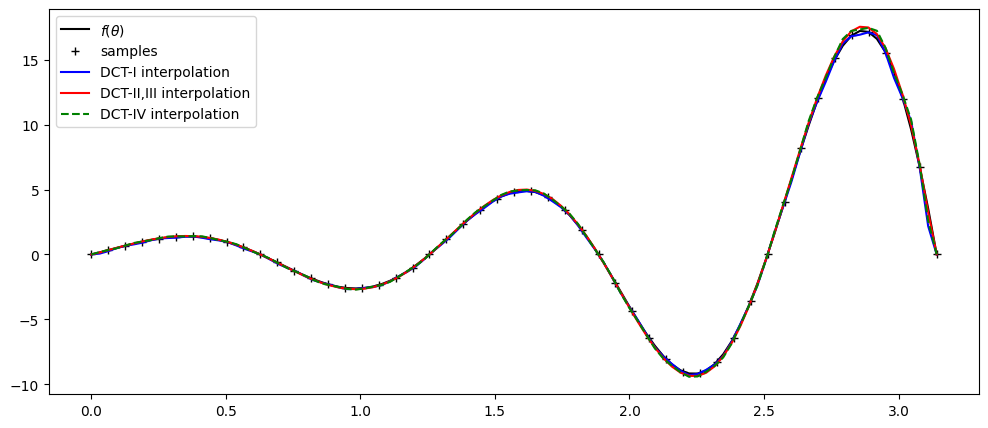

In [5]:
compare_dct(lambda th: np.exp(th) * np.sin(5*th), 50)

The DCT-I has now surpased the DCT-IV. What about with $N = 100$?

I error 0.00016208653199652453
II,III error 0.004049808210438948
IV error 0.00420313336056607


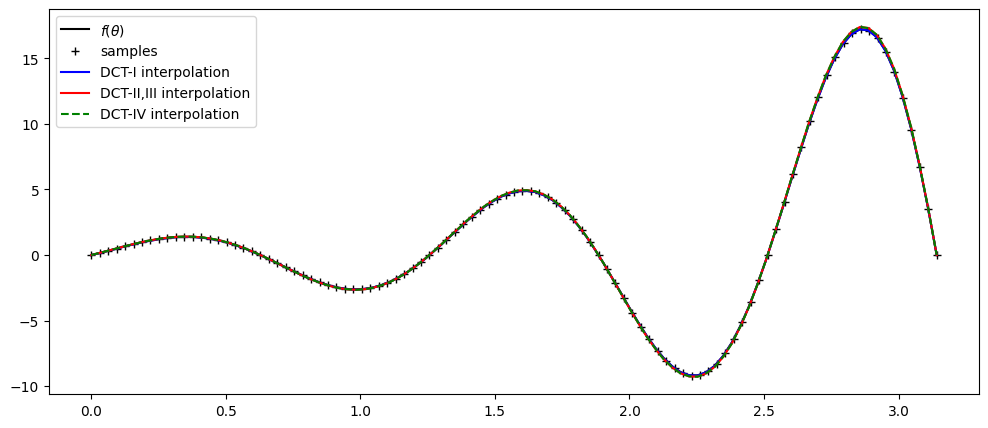

In [6]:
compare_dct(lambda th: np.exp(th) * np.sin(5*th), 100)

Now the DCT-I does *best*! So the DCT-I is the fastest-converging to the true underlying function, which in some sense makes *it* the truest.